In [1]:
!pip install spacy
!spacy download es_core_news_sm
!pip install --upgrade numpy
!pip install --upgrade pandas

  Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.14.1 requires numpy<2,>=1.18, but you have numpy 2.0.2 which is incompatible.


     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ------------------ --------------------- 6.0/12.9 MB 33.5 MB/s eta 0:00:01
     --------------------------------------- 12.9/12.9 MB 33.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.14.1 requires numpy<2,>=1.18, but you have numpy 2.1.3 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 2.1.3 which is incompatible.



  Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [20]:
import re
import csv
import json
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import spacy
from spellchecker import SpellChecker
spell = SpellChecker(language='es')
nlp = spacy.load('es_core_news_sm') # For lemmatizing the words

In [3]:
bills = pd.read_csv('./Clean/bills.csv')
bills.shape

(742, 10)

In [4]:
bills.head(10)

,Unnamed: 0,number,title,Autores,type_bill,year,period,state_bill,authors_positions,authors_count
0,0,PL331-22,PL 331-23 Seguridad Digital,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.666667,3.0
1,2,PL321-22,PL 321-23 Servicios Aereos,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],Proyecto de ley,2022-2023,2022 - 2026,archivado,1.000000,1.0
2,3,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.500000,8.0
3,4,PL319-22,PL 319-23 Violencia Vicaria,['NADIA GEORGETTE BLEL SCAFF'],Proyecto de ley,2022-2023,2022 - 2026,archivado,0.000000,1.0
4,5,PL309-22,PL 309-23 Corridas de Toros,"['Ministro de Cultura', 'Dr. JORGE IGNACIO ZOR...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.930233,43.0
5,6,PL308-22,PL 308-23 Ley Cero,"['KARINA ESPINOSA OLIVER', 'OSCAR MAURICIO GIR...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.054054,37.0
6,7,PL306-22,PL 306-23 Contraloría,"['JUAN FELIPE LEMOS URIBE', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.000000,23.0
7,8,PL305-22,PL 305-23 Administraciones Distritales,"['JORGE ELIECER TAMAYO MARULANDA', 'JOSÉ ELIÉC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.380952,21.0
8,9,PL304-22,PL 304-23 Medalla Edwin KemmererDescargar,"['JORGE BENEDETTI MARTELO', 'ROY BARRERAS MONT...",Proyecto de ley,2022-2023,2022 - 2026,ley,-0.379310,29.0
9,10,PL302-22,PL 302-23 Contratación,"['HONORIO MIGUEL HENRÍQUEZ PINEDO', 'ENRIQUE C...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-1.000000,14.0


In [5]:
# Read all the txt files in the folder and put them in an array in the order specified
# Returns also only the titles it found
def get_bills_text(bills_path, file_names):
  bills_txt = []
  names_found = []
  for bill in file_names:
    try:
      with open(bills_path + '/' + bill + '_ocr.txt', 'r', encoding="utf8") as f:
        bills_txt.append(f.read())
        names_found.append(bill)
    except FileNotFoundError:
      print(f"File {bill}_ocr.txt not found.")
  return bills_txt, names_found

In [6]:
file_names = bills['title'].values
    # Read all the txt files in the folder and put them in an array in the order specified
texts, bills_found = get_bills_text('./Raw/Bills_txt', file_names)
labels_df = bills[bills['title'].isin(bills_found)].copy()
labels_df.reset_index(drop=True, inplace=True)
print(labels_df.shape, len(texts))

File PL-284S-2023--196C-2022 Honores SalentoDescargar _ocr.txt not found.
File PL-271S-2022 Derecho a la gestion comunitaria del  agua_ocr.txt not found.
File PL-234 Convención interamericana contra toda forma de discriminación e intolerancia_ocr.txt not found.
File PL-225 Trabajador Bananero_ocr.txt not found.
File PL-224 Perros guia_ocr.txt not found.
File PL-223 Participacion de los jovenes_ocr.txt not found.
File PL-206 Divorcio_ocr.txt not found.
File PL-200 Canales de comercializacion para pequeños y medianos productores_ocr.txt not found.
File PL-199 Patrimonio Cultural Encuentro Nacional del Tiple - Envigado_ocr.txt not found.
File PL-189 Honores Jose Maria Cordoba_ocr.txt not found.
File PL-181 Politica de paz de estado_ocr.txt not found.
File PL-090 Protesta social_ocr.txt not found.
File PL 042-23 Hurto_ocr.txt not found.
File PL 252-24 Descargar _ocr.txt not found.
File PL 231-24 DIA DEL BOMBERO_ocr.txt not found.
File PL 185-24 POLÍTICA PÚBLICA DE AGUA_ocr.txt not found.
F

In [50]:
texts[4][:500]

'Pe CONGRESO cali DELAREPUÚ, DE COLOMBIA, 4. O Bogotá D.C., 26 de abril de 2023 Doctor GREGORIO ELJAS PACHECO Secretario General Senado de la República Bogotá D.C. REY: RADICACIÓN PROYECTO DE LEY Respetado Señor Secretario General: En nuestra condición de miembros del Congreso de la República y en uso del derecho consagrado en el artículo 150 de la Constitución Política de Colombia, por su digno conducto nos permitimos poner a consideración del Honorable Congreso de la República, el siguiente pro'

In [8]:
def check_word(word):
    return word.lower() not in spell.unknown([word])

In [9]:
def lemmatize_words(text, stop_words):
    words = text.split(' ')
    lemmatized = []
    for word in words:
        if check_word(word) and word not in stop_words:  # Check if the word exists in spanish or is a mistake from OCR or a typo or a stop word
            doc = nlp(word)
            if len(doc) > 0:
                lemmatized.append(doc[0].lemma_)
    return lemmatized

In [10]:
def text_preprocessing(texts, stop_words):
    text_cln = []
    for text in tqdm(texts):
        text = re.sub(r'[\W\d_]+', ' ', text.strip().lower())
        text_cln.append(' '.join(lemmatize_words(text, stop_words)))
        # text_cln.append(text)
    return text_cln

In [60]:
# https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
# Get stop words
stop_words = ['artículo', 'ley', 'congreso', 'cámara', 'senado', 'representantes', 'senador', 'senadora', 'ministerio', 'partido', 'político',
              'representante', 'colombia', 'república', 'edificio', 'calle', 'carrera', 'padilla', 'oficina', 'paloma', 'esmeralda',
              'teléfono', 'piso', 'proyecto', 'nacional', 'país', 'html', 'www', 'com', 'co', 'gov', 'público', 'presente', 'parágrafo', 'general', 
              'información']
with open('./Raw/spanish.txt', 'r', encoding="utf8") as f:
    for line in f:
        stop_words.append(line.strip())
# cleaning the names and last names that may appear in the text (congresspeople's names and heads of other entities)
# https://github.com/olea/lemarios/blob/master/nombres-propios-es.txt
# https://github.com/olea/lemarios/blob/master/apellidos-es.txt
with open('./Raw/nombres-propios-es.txt', 'r', encoding="utf8") as n:
    for line in n:
        stop_words.append(line.strip().lower())
with open('./Raw/apellidos-es.txt', 'r', encoding="utf8") as a:
    for line in a:
        stop_words.append(line.strip().lower())
len(stop_words)

1202

In [14]:
import os
if os.path.isfile("text_cln.pkl"):
    with open("text_cln.pkl", 'rb') as f:
        text_cln = pickle.load(f)
else:
    text_cln = text_preprocessing(texts, stop_words)

In [15]:
# Save the array to a pickle file
with open("text_cln.pkl", "wb") as f:
    pickle.dump(text_cln, f)

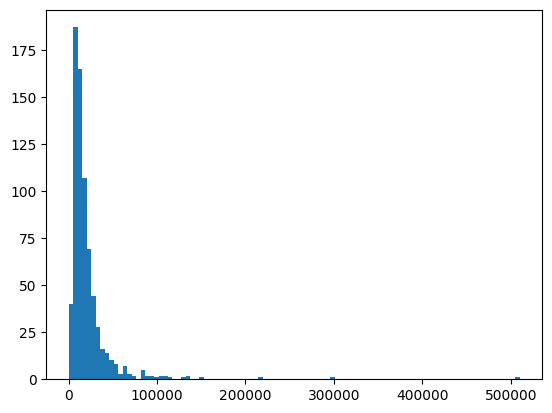

In [111]:
plt.hist([len(doc) for doc in text_cln], bins=100) 
plt.show()

In [97]:
tfidf_vect = TfidfVectorizer(min_df=50, stop_words=stop_words, sublinear_tf=True, strip_accents=None)
tfidf = tfidf_vect.fit_transform(text_cln)
tfidf.shape

(725, 2220)

In [98]:
text_cln[1][:500]

'mayo honorable secretario general asunto medio prestación presidente condición presente buscar regular prestación fortalecer forma consideración iniciar trámite correspondiente cumplir adjunto original documento copia medio magnético cordialmente pacto histórico medio prestación objeto presente objeto establecer servicio aéreo transporte público regular doméstico protección aplicar norma favorable conflicto servicio ámbito aplicación servicio transporte aéreo público doméstico dicho actividad fo'

In [99]:
search_params = {
  'n_components': [3, 4, 5, 7, 10, 15, 20, 30, 40],
  'learning_decay': [.5, .7]
}
# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(learning_method='online', random_state=14)

# Try all of the options
gridsearch = GridSearchCV(model, param_grid=search_params, n_jobs=-1, verbose=1)
gridsearch.fit(tfidf)

# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -24803.56462547052


In [100]:
LDA = LatentDirichletAllocation(random_state=14, learning_method='online', learning_decay= 0.7, n_components= 3)

In [101]:
theta = LDA.fit_transform(tfidf)
theta.shape

(725, 3)

In [102]:
beta = LDA.components_
beta.shape

(3, 2220)

In [106]:
topic_saliency = theta.sum(axis=0) / theta.sum()
topic_saliency

array([0.01923289, 0.01923163, 0.96153548])

In [103]:
# review top words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

In [104]:
features = tfidf_vect.get_feature_names_out()
print_top_words(model=LDA, feature_names = features, n_top_words = 20)

Topic #0: salud protección animal sistema vida derecho constitucional garantizar educación desarrollo humano transporte medio democracia necesario población relación orden corte constitución 

Topic #1: social gas decreto caso derecho forma colombiano nivel medio beneficio desarrollo comisión cuyo especial junio penal día constitucional policía programa 

Topic #2: medio desarrollo derecho social protección constitucional objeto interés gobierno año caso sistema educación salud constitución colombiano acuerdo democracia vida corte 




In [105]:
def plot_top_words(model, feature_names, n_top_words, topic_saliency, title):
    fig, axes = plt.subplots(1, len(topic_saliency), figsize=(30, 15), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        topic_dist = topic / topic.sum()  
        top_features_ind = topic_dist.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic_dist[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}\n({round(topic_saliency[topic_idx]*100, 2)}% of docs)", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

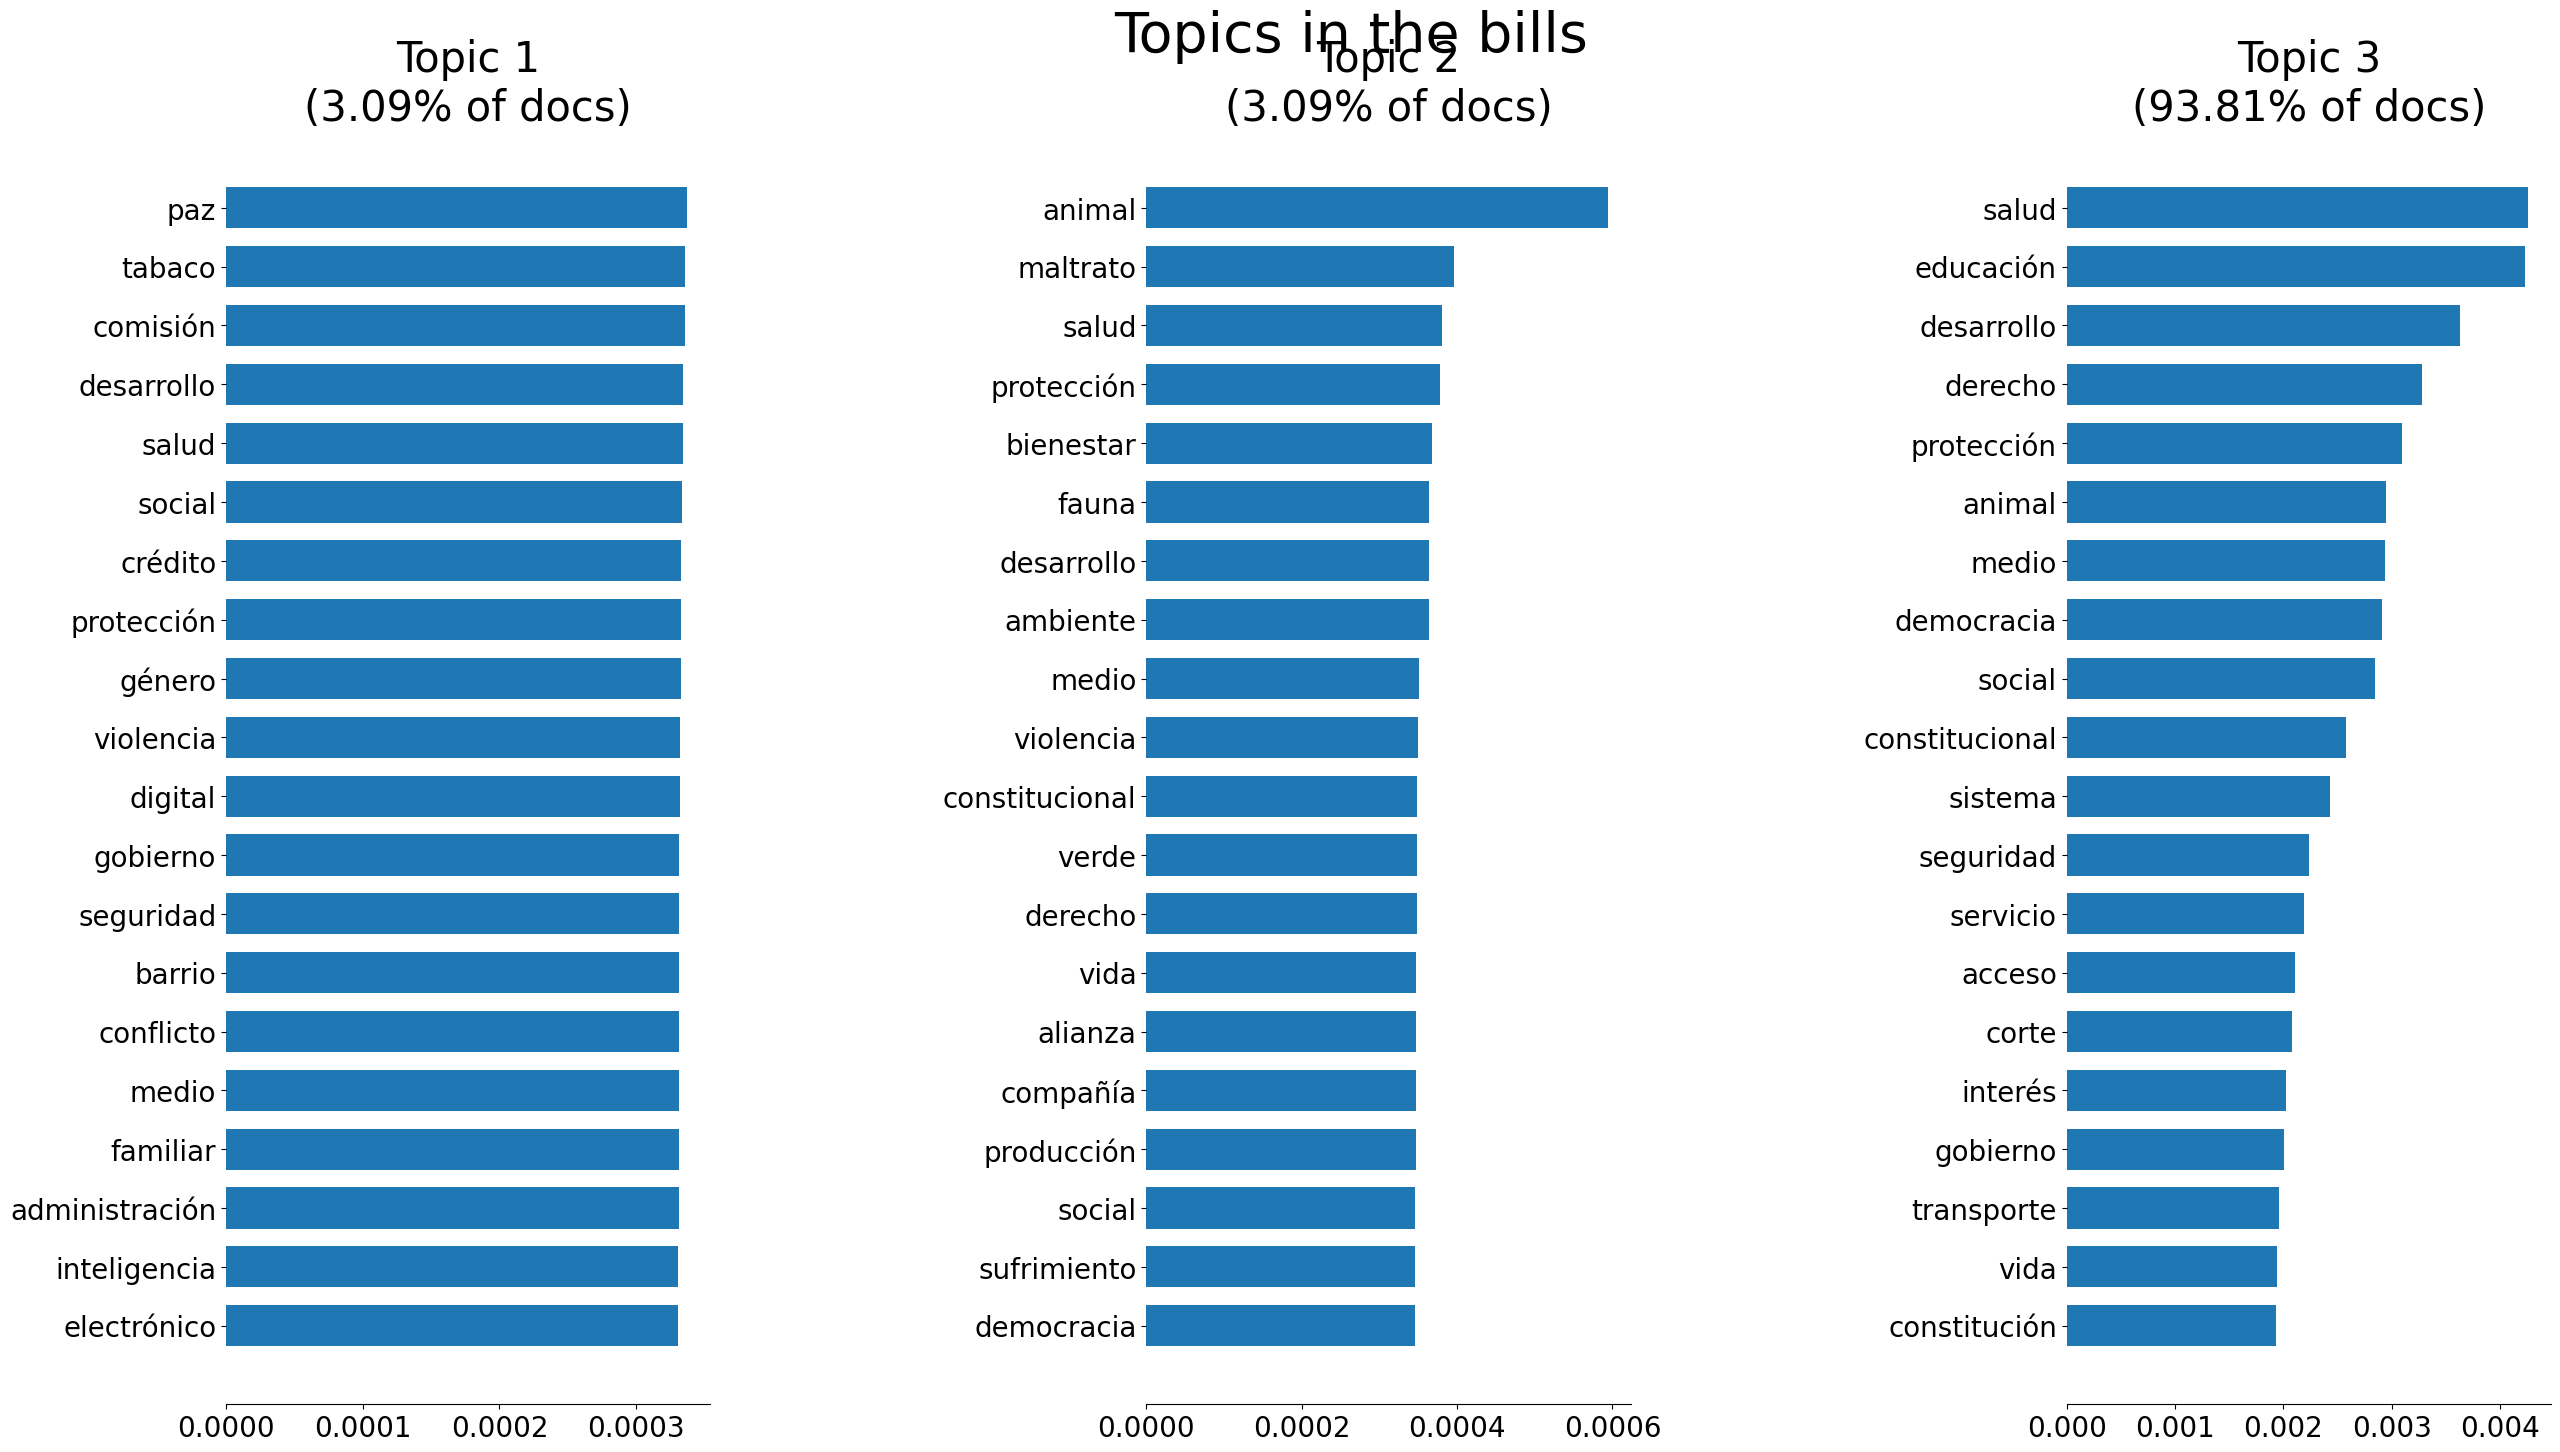

In [78]:
plot_top_words(model=LDA, feature_names = features, n_top_words = 20, title='Topics in the bills')

In [96]:
LDA = LatentDirichletAllocation(random_state=14, 
                                learning_method='online', 
                                learning_decay= 0.7,
                                max_iter=10,
                                learning_offset=50.,
                                n_components=7)
theta = LDA.fit_transform(tfidf)
topic_saliency = theta.sum(axis=0) / theta.sum()
topic_saliency

array([0.01296471, 0.0129647 , 0.01296472, 0.92221176, 0.01296469,
       0.01296469, 0.01296473])

In [93]:
print_top_words(model=LDA, feature_names = features, n_top_words = 20)

Topic #0: género vehículo juez policía interés paz liquidación acuerdo menor negociación providencia defensor población caso patrimonial página protección niña accidente militar 

Topic #1: paz deporte alerta lengua agencia vial terciario educación correo leal comisión seguimiento conjunto conflicto revisar nivel educativo calendario observar inmediatamente 

Topic #2: transporte agrario vial departamento municipio derecho proceso medio nación servicio desarrollo patrimonio comercio militar año bancado administrativo seguridad conservador protección 

Topic #3: salud educación desarrollo derecho protección animal medio democracia social constitucional sistema seguridad servicio acceso corte interés gobierno transporte vida constitución 

Topic #4: salud educación penal pena libertad superior animal artificial aseguramiento derecho resistencia matrícula cooperativo prisión juez mental inteligencia justicia descuento penitenciario 

Topic #5: conducción crédito fuego contrato transporte 

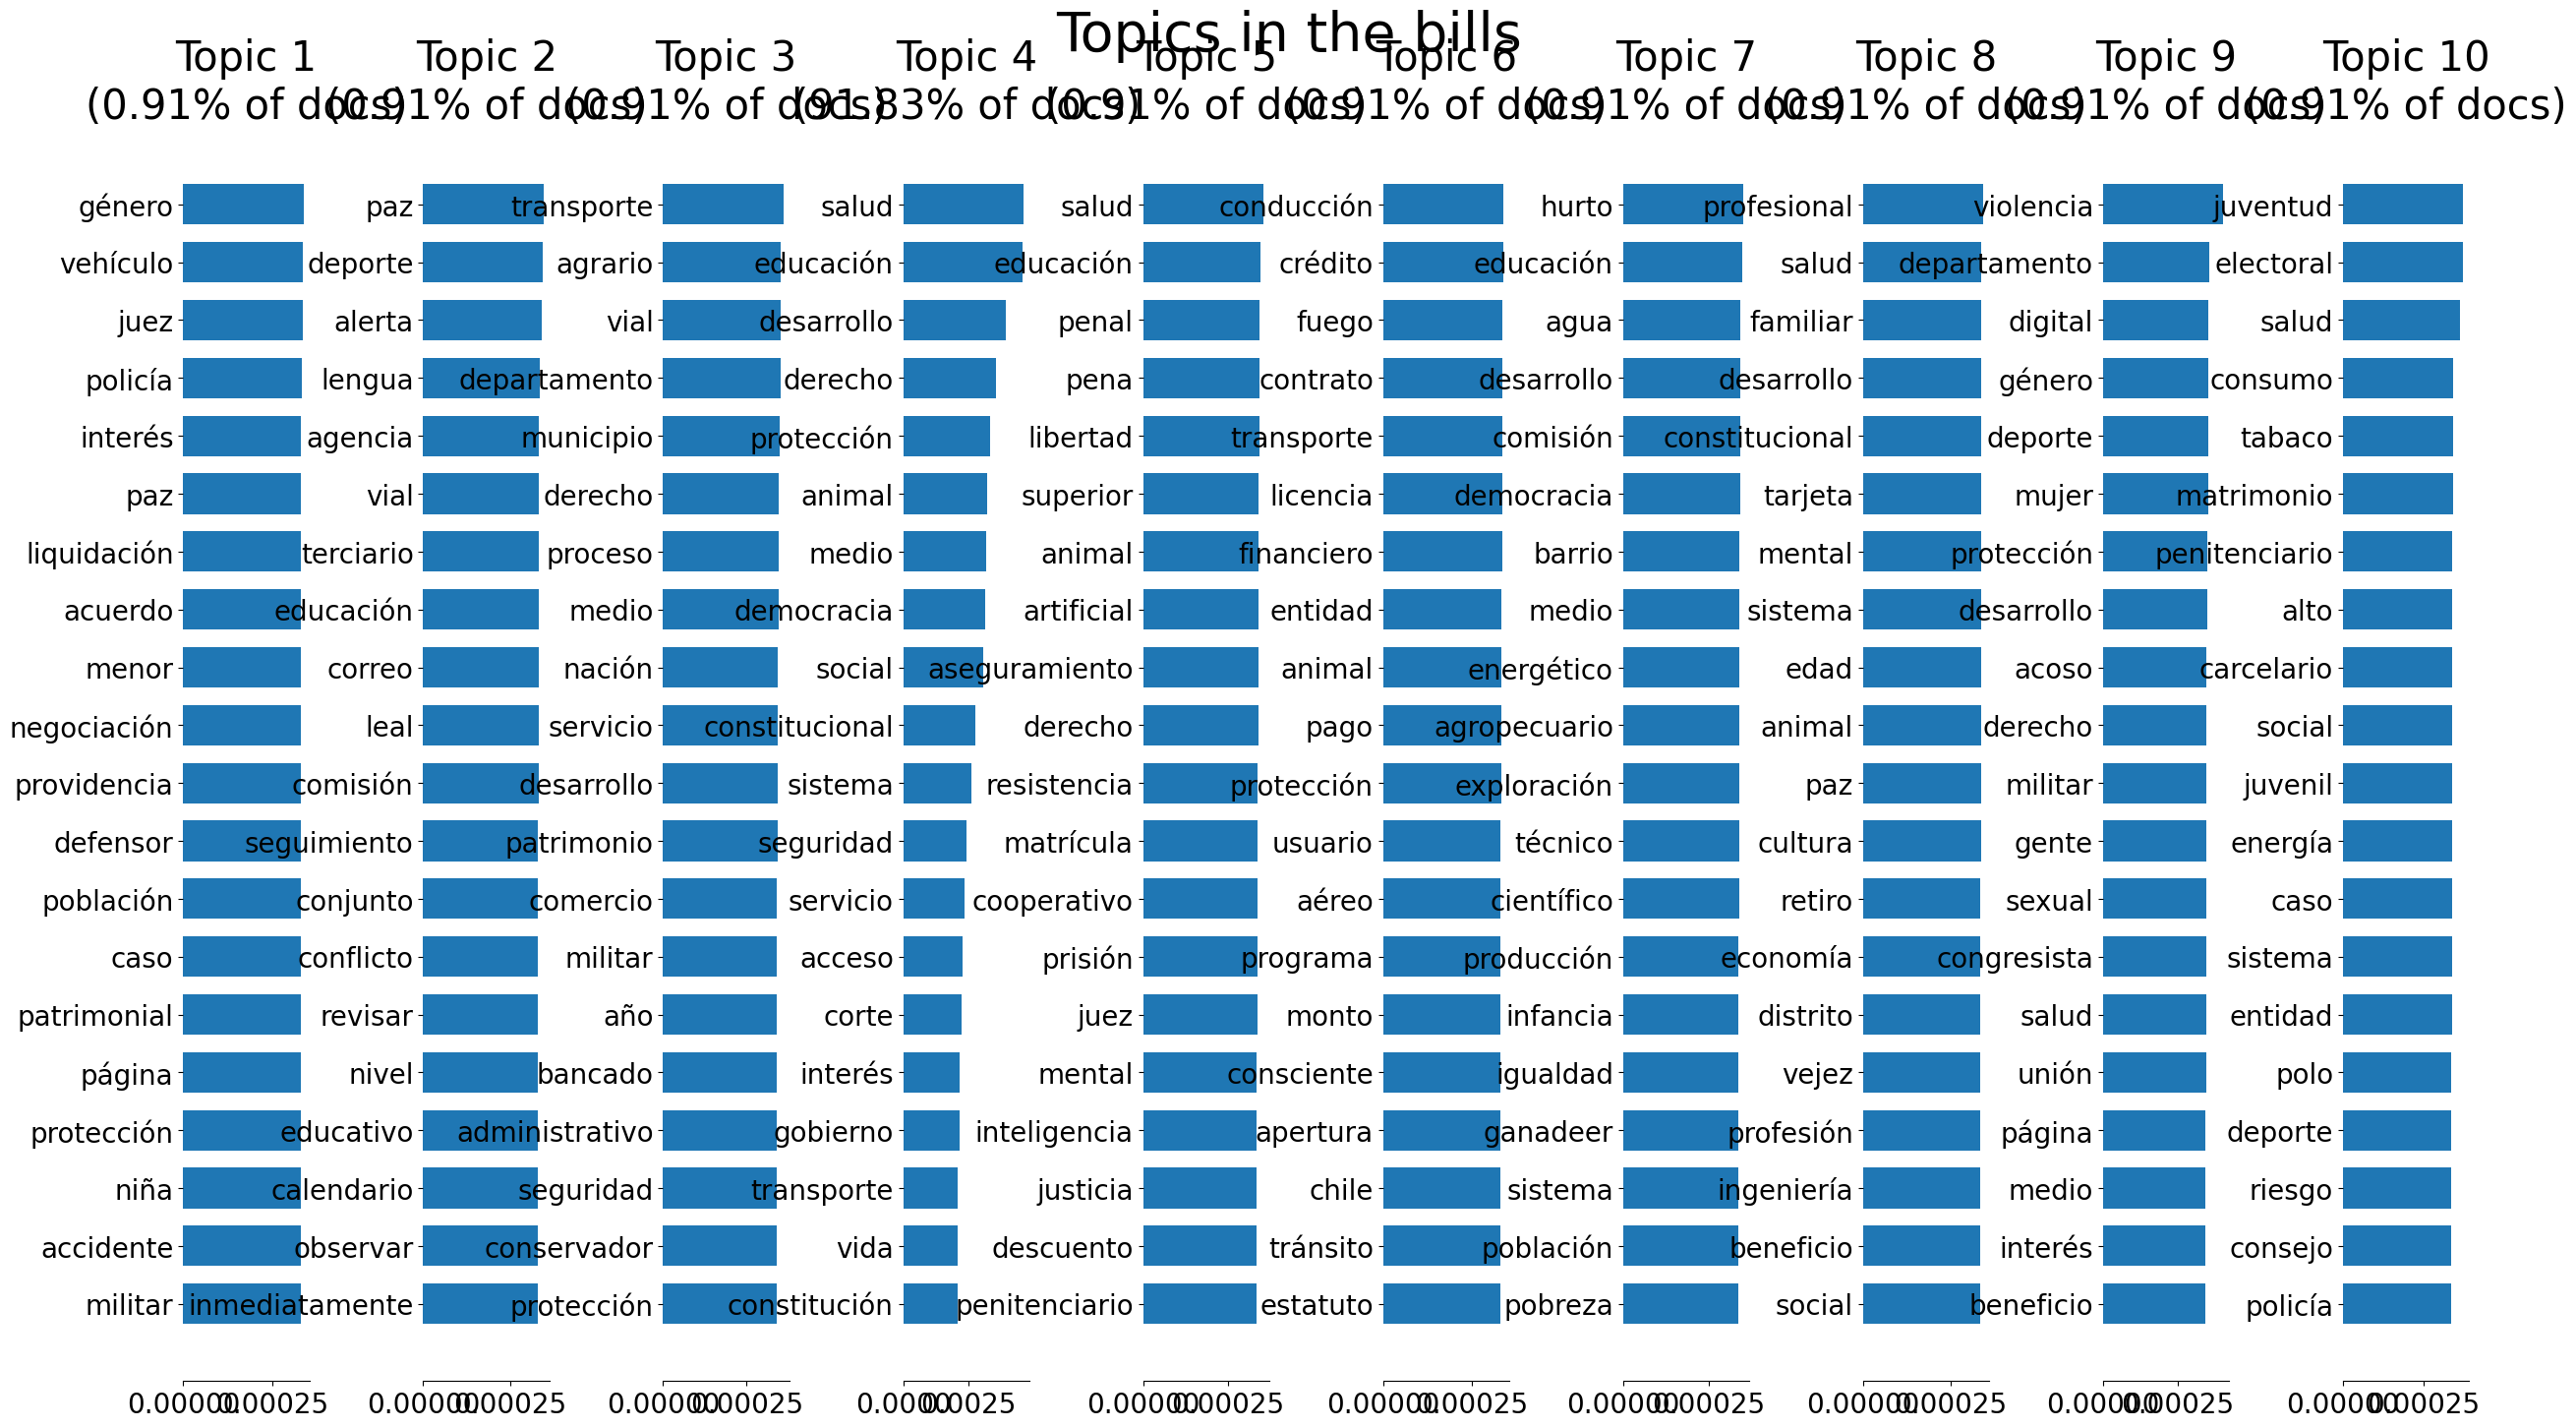

In [94]:
plot_top_words(model=LDA, feature_names = features, n_top_words = 20, topic_saliency=topic_saliency, title='Topics in the bills')